In [1]:
import json
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
sns.set_theme()

In [2]:
from experiments.experiment_config import (
    ALL_LIGHTNING_MODELS,
    DRIVE_AND_ACT_VIEWPOINTS,
    # get_drive_and_act_loaders,
    # two_actors_samples,
    # four_actors_samples,
    # driver_and_act_pretrained_map,
)
subset_percentage = [1, 2, 5, 10, 25, 50, 100]
actors = ['vp1', 'vp2', 'vp3', 'vp4', 'vp5', 'vp6', 'vp7', 'vp8']
# actors = ['vp1']
line_colors = sns.color_palette('muted')[1:]
marker_colors = sns.color_palette('dark')[1:]

def calculate_summary_results(metric):    
    saved_folder = Path(f'saved_lifter_2d_3d_model/rq2/')
    view_point_mean = {}
    view_point_stderr = {}
    for view_point in DRIVE_AND_ACT_VIEWPOINTS:
        view_point_mean[view_point] = {}
        view_point_stderr[view_point] = {}
        for model in ALL_LIGHTNING_MODELS:
            model_name = model.__name__
            simple_model_name = model_name.replace('Lit', '')
            raw_model_mean = []
            raw_model_stderr = []
            ft_model_mean = []
            ft_model_stderr = []
            improv_model_mean = []
            improv_model_stderr = []
            for subset in subset_percentage:
                raw_measure = []
                ft_measure = []
                for actor in actors:
                    raw_training_path = saved_folder / model_name / 'drive_and_act' / view_point / 'single_actor' / f'subset_{subset}' / actor
                    with (raw_training_path / 'test_result.json').open() as f:
                        data = json.loads(f.read())
                        raw_measure.append(data[metric])

                    transfer_learning_path = saved_folder / model_name / 'transfer_learning' / view_point / 'single_actor' / f'subset_{subset}' / actor
                    with (transfer_learning_path / 'test_result.json').open() as f:
                        data = json.loads(f.read())
                        ft_measure.append(data[metric])
                raw_mean, raw_stderr = np.mean(raw_measure), stats.sem(raw_measure)
                raw_model_mean.append(raw_mean)
                raw_model_stderr.append(raw_stderr)

                ft_mean, ft_stderr = np.mean(ft_measure), stats.sem(ft_measure)
                ft_model_mean.append(ft_mean)
                ft_model_stderr.append(ft_stderr)

                improv_measure = (np.array(raw_measure) - np.array(ft_measure)).tolist()
                improv_mean, improv_stderr = np.mean(improv_measure), stats.sem(improv_measure)
                improv_model_mean.append(improv_mean)
                improv_model_stderr.append(improv_stderr)

            view_point_mean[view_point][simple_model_name] = {
                'raw': raw_model_mean,
                'ft': ft_model_mean,
                'improv': improv_model_mean,
            }
            view_point_stderr[view_point][simple_model_name] = {
                'raw': raw_model_stderr,
                'ft': ft_model_stderr,
                'improv': improv_model_stderr
            }
    return view_point_mean, view_point_stderr

In [3]:
def plot_result(
        metric,
        view_point,
        view_point_mean,
        view_point_stderr,
        markersize=3,
        elinewidth=1,
        capsize=3,
        legend_font_size=8,
    ):
    fig = plt.figure(figsize=(12, 16), constrained_layout = True)
    fig.suptitle(f'{metric} | view: {view_point}', fontsize=20)
    subfigs = fig.subfigures(len(ALL_LIGHTNING_MODELS), 1, wspace=0.07)
    for i, model in enumerate(ALL_LIGHTNING_MODELS):
        axes = subfigs[i].subplots(1, 2)
        model_name = model.__name__
        simple_model_name = model_name.replace('Lit', '')
        subfigs[i].suptitle(simple_model_name)
        # axes[0].set_title(simple_model_name)
        axes[0].set_ylabel('MPJPE [mm]')
        axes[0].set_xlabel('Percentage of samples')
        axes[0].set(xticks=subset_percentage)
        axes[0].set_ylim(50, 120)
        raw_values = view_point_mean[view_point][simple_model_name]['raw']
        raw_stderr = view_point_stderr[view_point][simple_model_name]['raw']
        axes[0].plot(
            subset_percentage,
            raw_values,
            color=line_colors[i],
            linestyle='dashed',
            label='No Pretrained'
        )
        axes[0].errorbar(
            subset_percentage,
            raw_values,
            yerr=raw_stderr,
            fmt='s',
            color=marker_colors[i],
            elinewidth=elinewidth,
            capsize=capsize,
            markersize=markersize,
            label='Standard Error'
        )
        ft_values = view_point_mean[view_point][simple_model_name]['ft']
        ft_stderr = view_point_stderr[view_point][simple_model_name]['ft']
        axes[0].plot(
            subset_percentage,
            ft_values,
            color=line_colors[i],
            label='Pretrained'
        )
        axes[0].errorbar(
            subset_percentage,
            ft_values,
            yerr=ft_stderr,
            fmt='o',
            elinewidth=elinewidth,
            capsize=capsize,
            markersize=markersize,
            color=marker_colors[i],
            label='Standard Error'
        )
        axes[0].legend(prop={'size': legend_font_size})

        improv_values = view_point_mean[view_point][simple_model_name]['improv']
        improv_stderr = view_point_stderr[view_point][simple_model_name]['improv']
        # axes[1].set_title(simple_model_name)
        axes[1].step(
            subset_percentage,
            improv_values,
            color=line_colors[i],
            label='Reduction by pretraining',
            where='post'
        )
        axes[1].errorbar(
            subset_percentage,
            improv_values,
            yerr=improv_stderr,
            fmt='o',
            elinewidth=elinewidth,
            capsize=capsize,
            markersize=markersize,
            color=marker_colors[i],
            label='Standard Error'
        )
        axes[1].set_ylabel('MPJPE [mm]')
        axes[1].set_xlabel('Percentage of samples')
        axes[1].set(xticks=subset_percentage)
        axes[1].set_ylim(0, 30)
        axes[1].legend(prop={'size': legend_font_size})
    plt.savefig(f'{metric}_{view_point}')

In [4]:
def get_summarize_table(view_point, subset_percentage, view_point_mean, view_point_stderr):
    raws = {}
    fts = {}
    for model in view_point_mean[view_point].keys():
        raws[model] = view_point_mean[view_point][model]['raw']
        fts[model] = view_point_mean[view_point][model]['ft']
    raw_df = pd.DataFrame(raws, index=subset_percentage).T
    ft_df = pd.DataFrame(fts, index=subset_percentage).T
    return raw_df, ft_df

def print_table(df):
    # with pd.option_context('precision', 2):
    with pd.option_context('float_format', '{:.2f}'.format):
        display(df)

'No Pretrained'

,1,2,5,10,25,50,100
SimpleBaselineLinear,416.89,222.87,94.20,71.06,70.40,64.97,62.81
SemGCN,88.85,87.45,80.64,80.92,75.61,75.13,70.03
GraphMLP,81.86,84.48,83.03,73.60,68.74,64.90,63.95
Graformer,80.71,78.84,75.52,71.96,69.55,67.55,65.55
JointFormer,102.40,97.46,90.10,84.11,73.34,67.27,63.06


'Pretrained'

,1,2,5,10,25,50,100
SimpleBaselineLinear,79.03,70.76,68.42,65.36,64.23,62.43,60.83
SemGCN,83.75,77.39,75.14,72.67,71.25,67.52,64.76
GraphMLP,74.03,68.59,69.11,68.72,66.94,65.76,62.75
Graformer,77.43,72.07,69.86,68.34,66.72,65.15,64.13
JointFormer,76.01,68.96,69.19,66.87,64.24,63.43,61.29


'Diff'

,1,2,5,10,25,50,100
SimpleBaselineLinear,337.86,152.11,25.77,5.70,6.17,2.53,1.98
SemGCN,5.10,10.06,5.50,8.26,4.35,7.62,5.27
GraphMLP,7.84,15.89,13.92,4.88,1.80,-0.86,1.20
Graformer,3.28,6.77,5.66,3.62,2.83,2.41,1.43
JointFormer,26.39,28.51,20.91,17.25,9.10,3.83,1.78


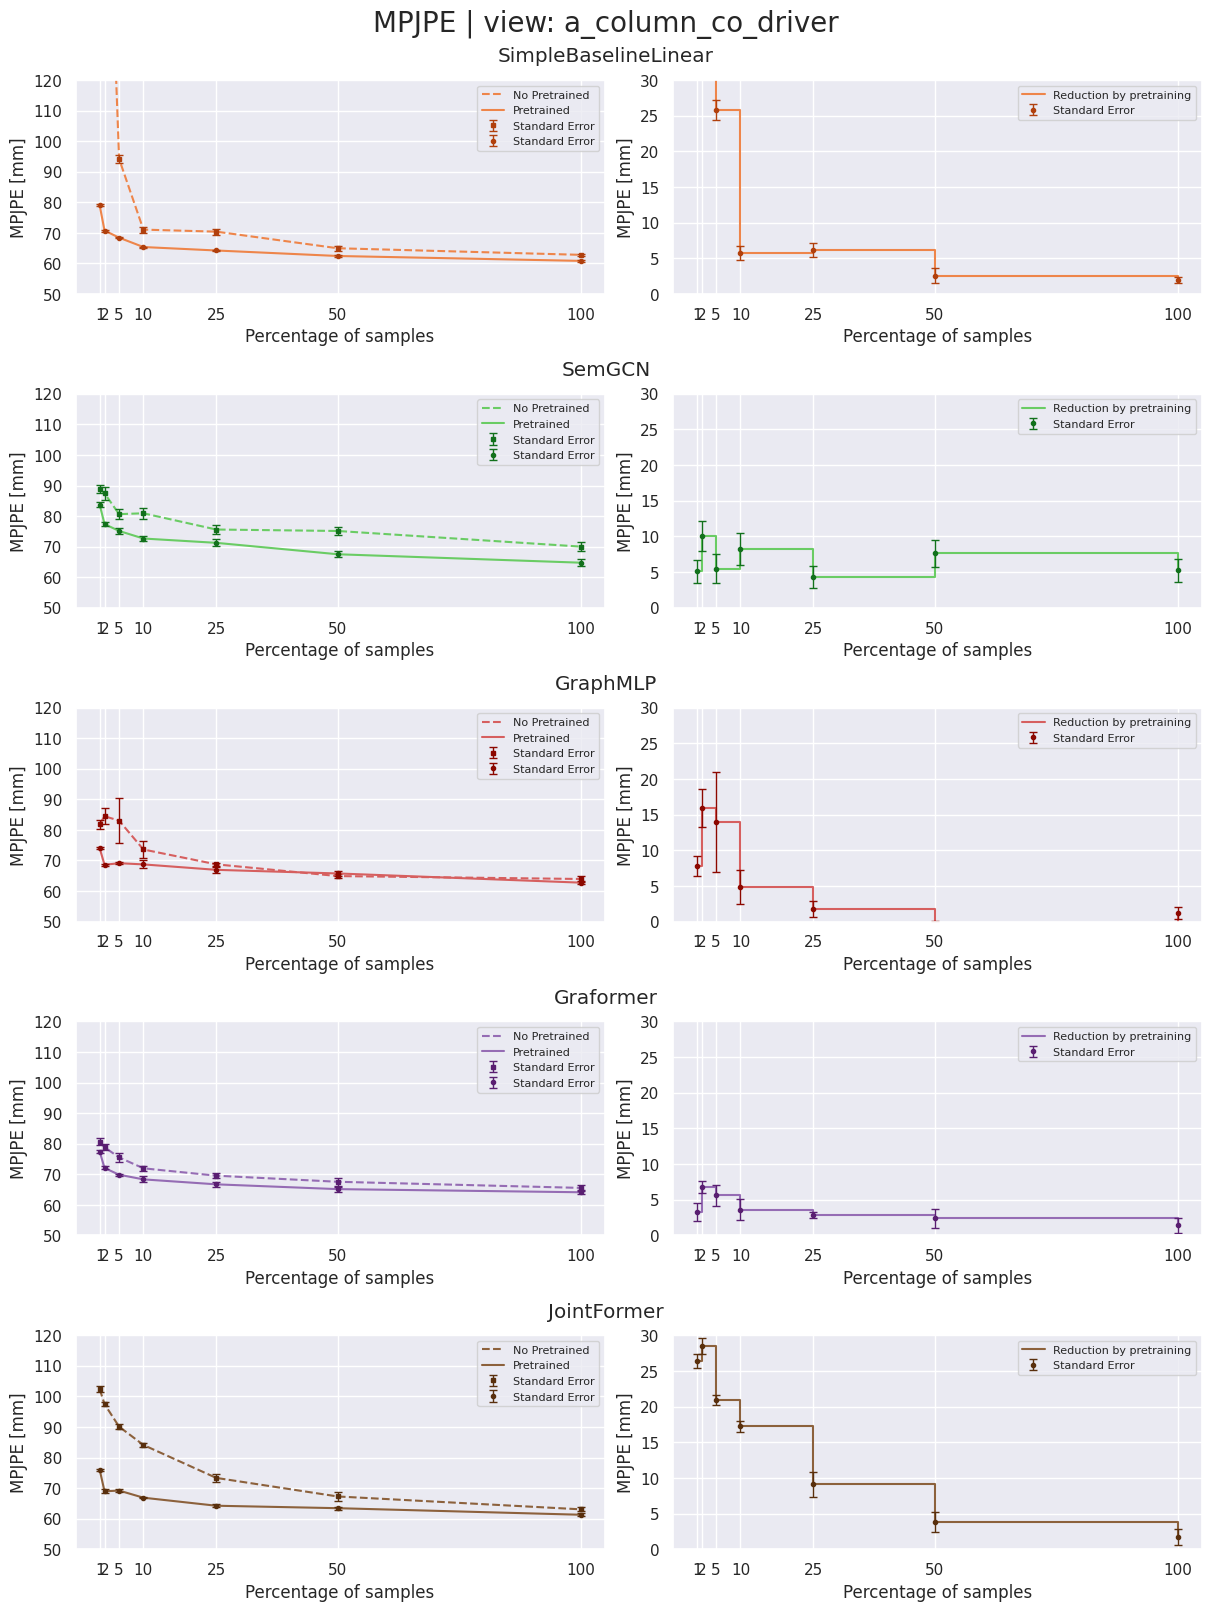

In [5]:
view_point_mean, view_point_stderr = calculate_summary_results('mpjpe')
raw_df, ft_df = get_summarize_table(DRIVE_AND_ACT_VIEWPOINTS[0], subset_percentage, view_point_mean, view_point_stderr)
display('No Pretrained')
print_table(raw_df)
display('Pretrained')
print_table(ft_df)
display('Diff')
print_table(raw_df - ft_df)
plot_result('MPJPE', DRIVE_AND_ACT_VIEWPOINTS[0], view_point_mean, view_point_stderr)

'No Pretrained'

,1,2,5,10,25,50,100
SimpleBaselineLinear,492.92,210.98,95.86,79.48,77.72,70.46,66.54
SemGCN,137.95,102.67,93.55,91.13,85.64,82.85,76.34
GraphMLP,95.62,89.97,84.26,79.00,75.71,71.26,69.89
Graformer,89.00,86.92,82.00,77.44,75.74,72.80,70.99
JointFormer,107.67,103.20,95.58,87.34,79.54,69.71,67.36


'Pretrained'

,1,2,5,10,25,50,100
SimpleBaselineLinear,89.22,80.71,77.48,73.21,70.56,68.16,67.06
SemGCN,99.12,90.02,80.99,78.06,73.52,71.98,69.00
GraphMLP,82.43,81.34,78.70,73.70,71.69,68.50,67.22
Graformer,84.26,81.51,78.33,74.67,71.60,70.20,66.37
JointFormer,84.25,77.42,75.38,72.58,71.24,68.38,66.44


'Diff'

,1,2,5,10,25,50,100
SimpleBaselineLinear,403.70,130.27,18.38,6.27,7.16,2.30,-0.52
SemGCN,38.83,12.65,12.56,13.07,12.12,10.87,7.33
GraphMLP,13.19,8.63,5.57,5.30,4.02,2.76,2.68
Graformer,4.74,5.42,3.67,2.77,4.14,2.60,4.63
JointFormer,23.43,25.78,20.19,14.75,8.30,1.33,0.92


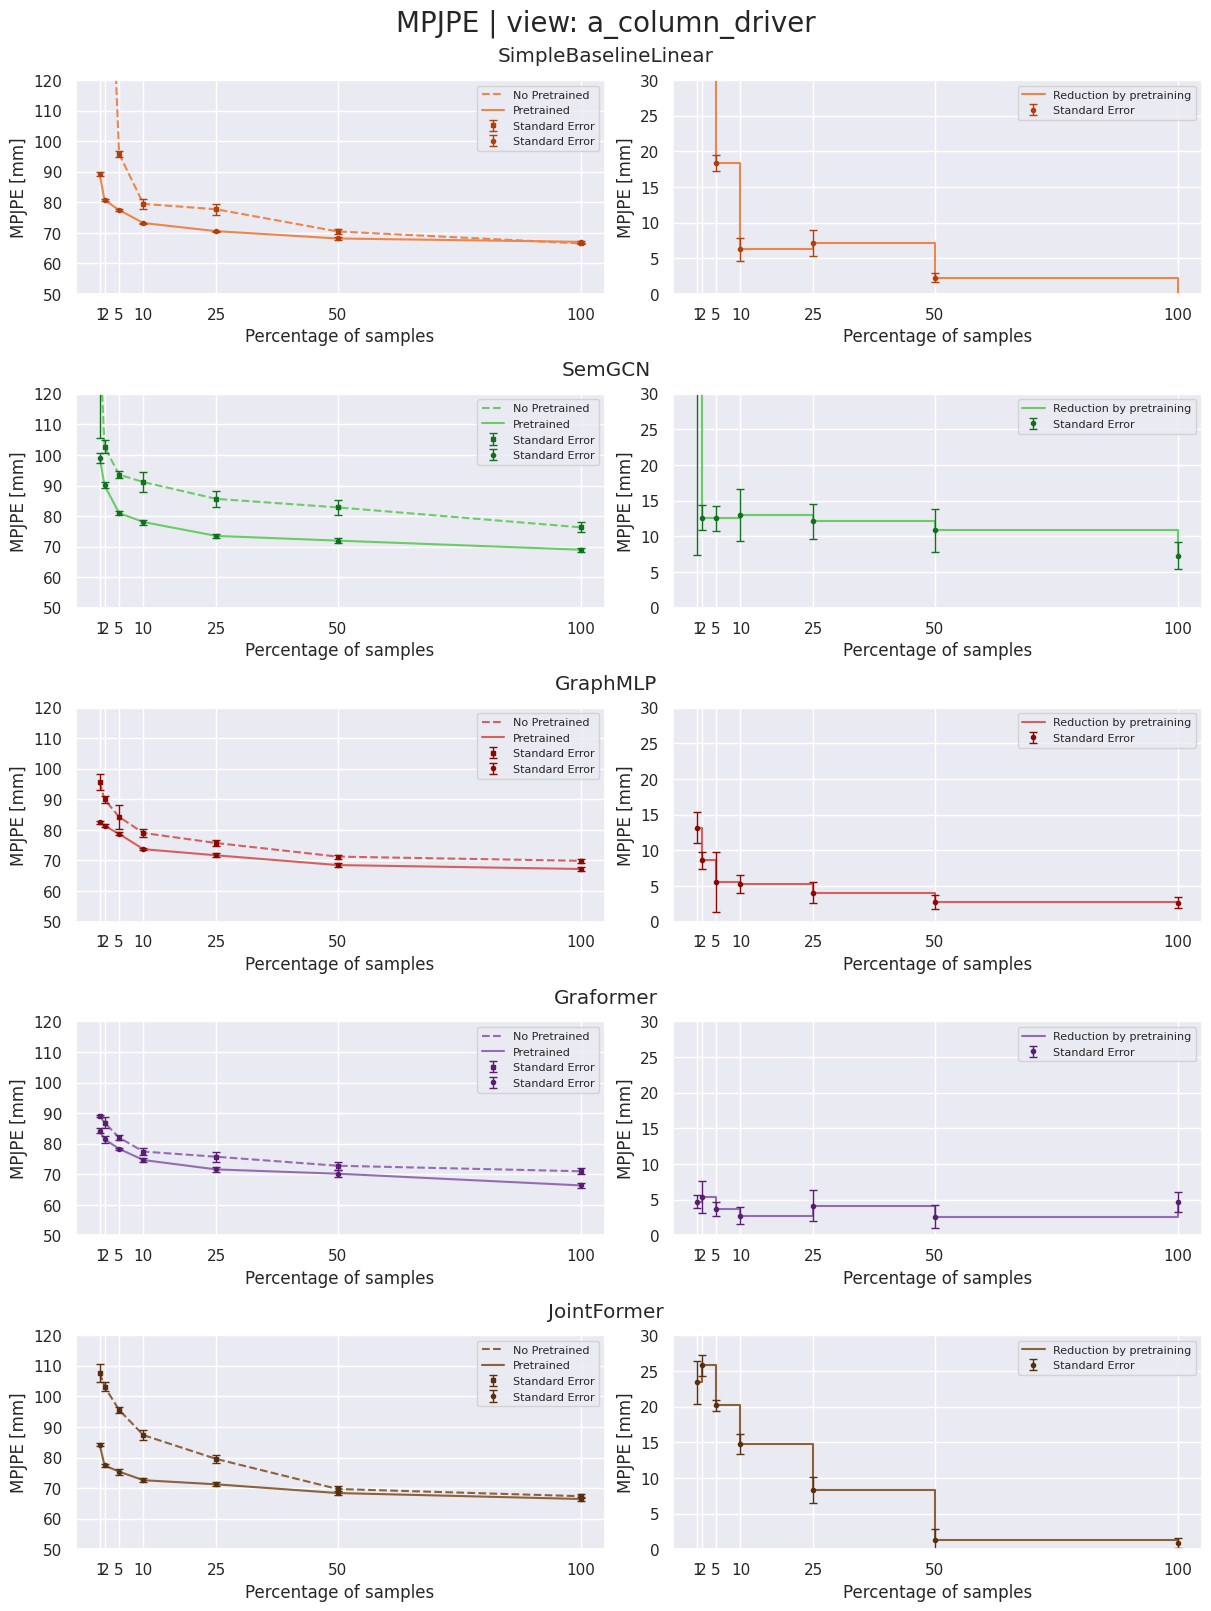

In [6]:
view_point_mean, view_point_stderr = calculate_summary_results('mpjpe')
raw_df, ft_df = get_summarize_table(DRIVE_AND_ACT_VIEWPOINTS[1], subset_percentage, view_point_mean, view_point_stderr)
display('No Pretrained')
print_table(raw_df)
display('Pretrained')
print_table(ft_df)
display('Diff')
print_table(raw_df - ft_df)
plot_result('MPJPE', DRIVE_AND_ACT_VIEWPOINTS[1], view_point_mean, view_point_stderr)

'No Pretrained'

,1,2,5,10,25,50,100
SimpleBaselineLinear,519.04,204.88,85.24,63.25,59.93,54.95,53.00
SemGCN,92.46,79.52,74.79,71.37,68.98,64.78,59.61
GraphMLP,79.51,74.98,67.88,62.91,56.21,53.50,52.94
Graformer,83.79,74.25,66.98,63.72,58.48,56.83,54.16
JointFormer,114.49,99.48,88.52,83.70,61.56,55.12,50.79


'Pretrained'

,1,2,5,10,25,50,100
SimpleBaselineLinear,75.23,61.59,59.69,58.54,54.11,51.41,50.58
SemGCN,71.92,62.86,60.29,59.27,57.68,57.67,55.59
GraphMLP,61.97,54.37,54.12,56.23,52.22,52.14,51.70
Graformer,69.97,56.80,56.30,56.87,54.75,54.56,52.16
JointFormer,67.47,57.85,52.74,54.94,53.61,53.15,49.81


'Diff'

,1,2,5,10,25,50,100
SimpleBaselineLinear,443.81,143.29,25.55,4.71,5.82,3.54,2.42
SemGCN,20.55,16.66,14.51,12.09,11.30,7.11,4.03
GraphMLP,17.53,20.61,13.76,6.67,3.99,1.36,1.24
Graformer,13.82,17.45,10.68,6.86,3.73,2.27,1.99
JointFormer,47.02,41.63,35.79,28.76,7.96,1.97,0.99


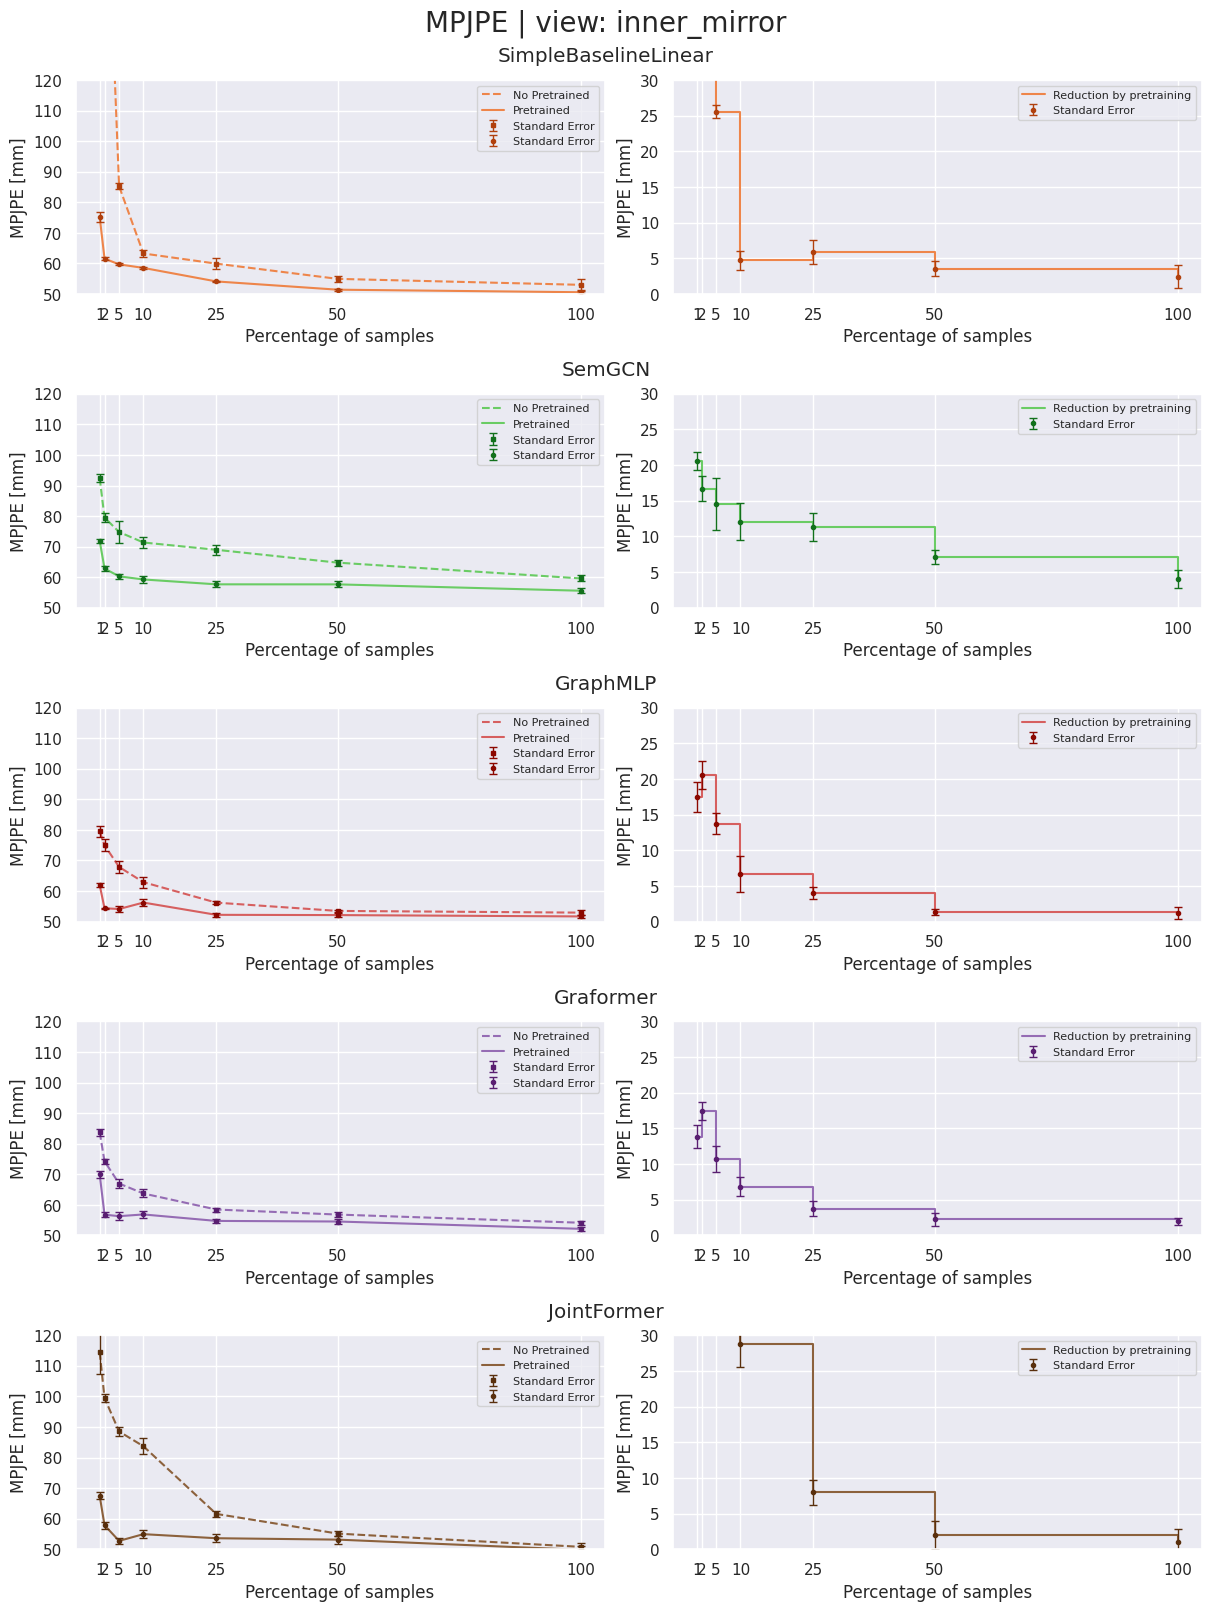

In [7]:
view_point_mean, view_point_stderr = calculate_summary_results('mpjpe')
raw_df, ft_df = get_summarize_table(DRIVE_AND_ACT_VIEWPOINTS[2], subset_percentage, view_point_mean, view_point_stderr)
display('No Pretrained')
print_table(raw_df)
display('Pretrained')
print_table(ft_df)
display('Diff')
print_table(raw_df - ft_df)
plot_result('MPJPE', DRIVE_AND_ACT_VIEWPOINTS[2], view_point_mean, view_point_stderr)

'No Pretrained'

,1,2,5,10,25,50,100
SimpleBaselineLinear,425.80,235.89,110.21,87.91,87.29,82.17,80.22
SemGCN,104.62,104.66,97.26,97.53,92.59,91.82,86.96
GraphMLP,97.54,100.08,98.69,90.37,85.71,81.90,81.10
Graformer,97.13,95.53,92.54,89.19,86.74,84.82,83.26
JointFormer,118.40,113.17,105.72,100.13,90.27,84.65,80.97


'Pretrained'

,1,2,5,10,25,50,100
SimpleBaselineLinear,95.72,88.40,85.59,82.68,81.53,79.78,78.38
SemGCN,100.39,95.20,92.16,89.81,88.29,84.66,82.14
GraphMLP,90.82,86.44,86.25,85.61,84.00,83.06,80.11
Graformer,93.80,89.80,87.06,85.49,83.97,82.45,81.49
JointFormer,92.69,86.72,86.23,84.38,81.42,80.74,79.32


'Diff'

,1,2,5,10,25,50,100
SimpleBaselineLinear,330.08,147.49,24.62,5.23,5.76,2.39,1.83
SemGCN,4.23,9.46,5.10,7.72,4.30,7.16,4.81
GraphMLP,6.72,13.63,12.44,4.76,1.71,-1.16,0.99
Graformer,3.32,5.73,5.48,3.70,2.76,2.36,1.77
JointFormer,25.71,26.45,19.49,15.75,8.85,3.91,1.64


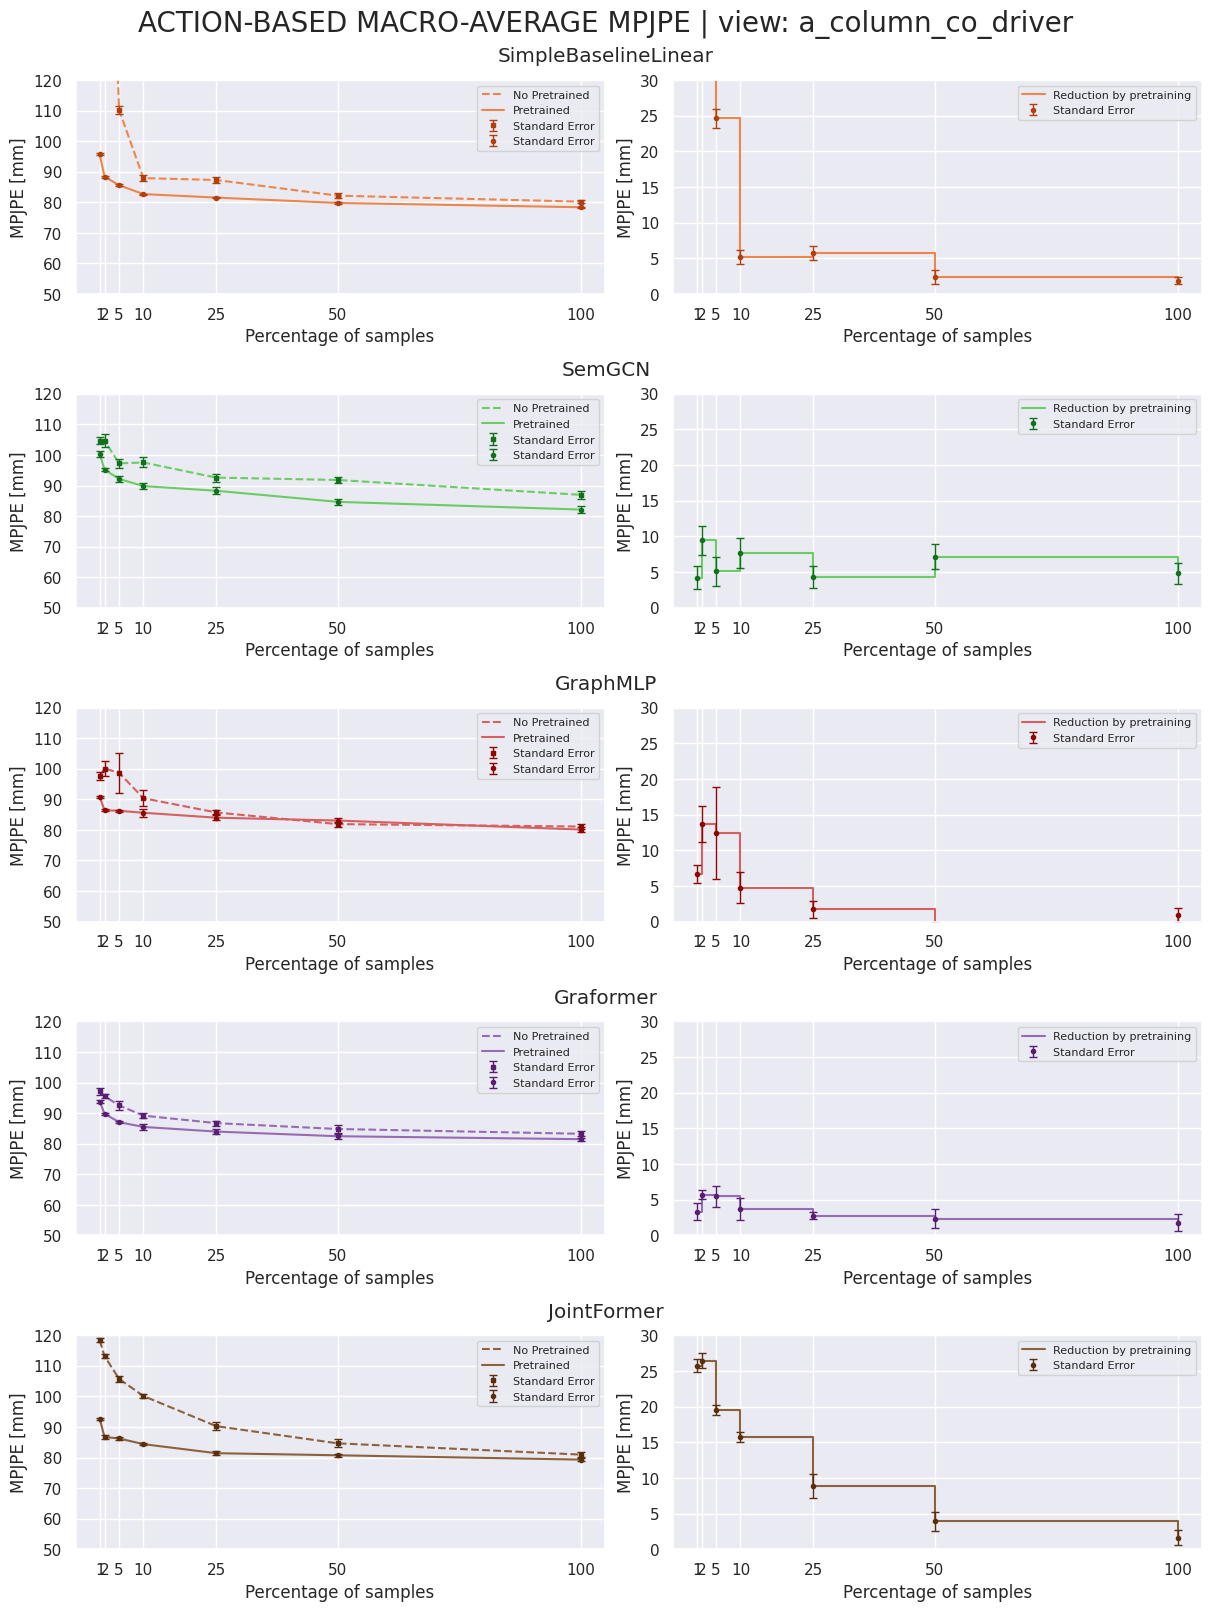

In [8]:
view_point_mean, view_point_stderr = calculate_summary_results('activity_macro_mpjpe')
raw_df, ft_df = get_summarize_table(DRIVE_AND_ACT_VIEWPOINTS[0], subset_percentage, view_point_mean, view_point_stderr)
display('No Pretrained')
print_table(raw_df)
display('Pretrained')
print_table(ft_df)
display('Diff')
print_table(raw_df - ft_df)
plot_result('ACTION-BASED MACRO-AVERAGE MPJPE', DRIVE_AND_ACT_VIEWPOINTS[0], view_point_mean, view_point_stderr)

'No Pretrained'

,1,2,5,10,25,50,100
SimpleBaselineLinear,502.51,224.80,112.58,96.82,94.90,87.76,84.98
SemGCN,152.36,119.49,110.04,107.83,102.24,99.92,94.35
GraphMLP,112.04,106.58,101.38,96.22,92.85,88.89,88.21
Graformer,105.60,104.11,99.25,94.82,93.32,90.34,89.22
JointFormer,124.77,119.76,111.75,104.05,96.47,87.22,85.81


'Pretrained'

,1,2,5,10,25,50,100
SimpleBaselineLinear,106.14,98.97,95.07,90.82,88.10,85.75,85.62
SemGCN,115.89,107.71,98.49,95.46,90.83,89.46,87.50
GraphMLP,99.74,99.22,96.13,91.10,89.40,86.02,85.76
Graformer,101.50,99.15,96.05,92.45,88.96,87.65,84.59
JointFormer,102.01,95.54,93.05,90.12,88.80,86.18,84.99


'Diff'

,1,2,5,10,25,50,100
SimpleBaselineLinear,396.37,125.83,17.51,6.00,6.80,2.01,-0.64
SemGCN,36.47,11.78,11.55,12.37,11.41,10.47,6.85
GraphMLP,12.30,7.36,5.25,5.12,3.45,2.87,2.45
Graformer,4.10,4.96,3.20,2.37,4.36,2.69,4.63
JointFormer,22.76,24.22,18.70,13.93,7.67,1.04,0.81


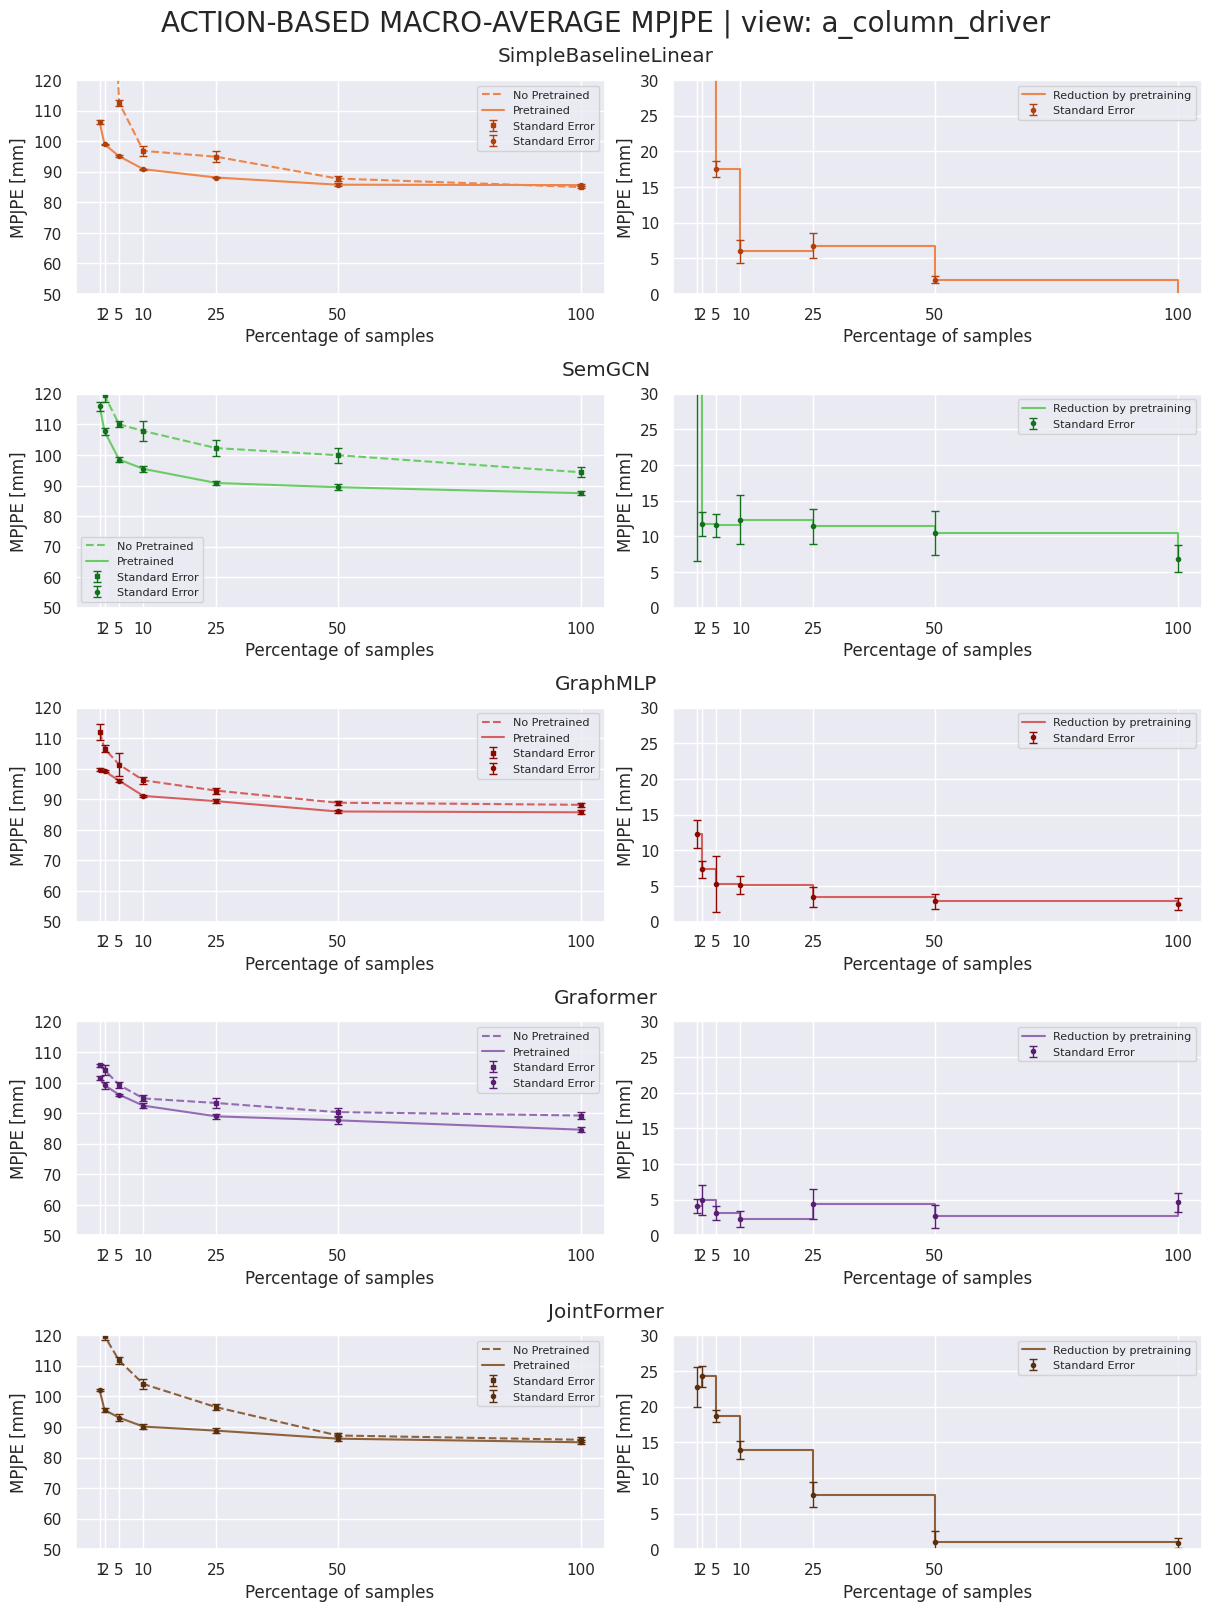

In [9]:
view_point_mean, view_point_stderr = calculate_summary_results('activity_macro_mpjpe')
raw_df, ft_df = get_summarize_table(DRIVE_AND_ACT_VIEWPOINTS[1], subset_percentage, view_point_mean, view_point_stderr)
display('No Pretrained')
print_table(raw_df)
display('Pretrained')
print_table(ft_df)
display('Diff')
print_table(raw_df - ft_df)
plot_result('ACTION-BASED MACRO-AVERAGE MPJPE', DRIVE_AND_ACT_VIEWPOINTS[1], view_point_mean, view_point_stderr)

'No Pretrained'

,1,2,5,10,25,50,100
SimpleBaselineLinear,527.96,220.49,103.85,82.98,79.57,74.77,73.22
SemGCN,111.81,98.98,94.30,91.21,88.54,84.99,79.73
GraphMLP,97.63,93.74,87.60,82.81,76.26,73.61,72.93
Graformer,103.39,93.91,87.18,83.66,78.29,76.87,73.69
JointFormer,131.12,116.45,106.25,101.58,81.25,75.07,70.89


'Pretrained'

,1,2,5,10,25,50,100
SimpleBaselineLinear,93.77,81.96,79.48,78.83,74.36,71.80,71.20
SemGCN,92.70,83.29,80.50,79.39,78.30,78.10,75.57
GraphMLP,82.65,75.13,74.38,76.70,72.61,72.60,72.12
Graformer,90.72,76.97,76.43,77.29,75.16,74.81,72.29
JointFormer,88.26,78.40,72.94,75.21,73.97,73.73,70.24


'Diff'

,1,2,5,10,25,50,100
SimpleBaselineLinear,434.18,138.52,24.38,4.15,5.21,2.97,2.03
SemGCN,19.11,15.70,13.80,11.82,10.24,6.89,4.16
GraphMLP,14.97,18.61,13.23,6.11,3.65,1.01,0.80
Graformer,12.67,16.94,10.75,6.36,3.12,2.05,1.40
JointFormer,42.86,38.05,33.31,26.37,7.27,1.35,0.66


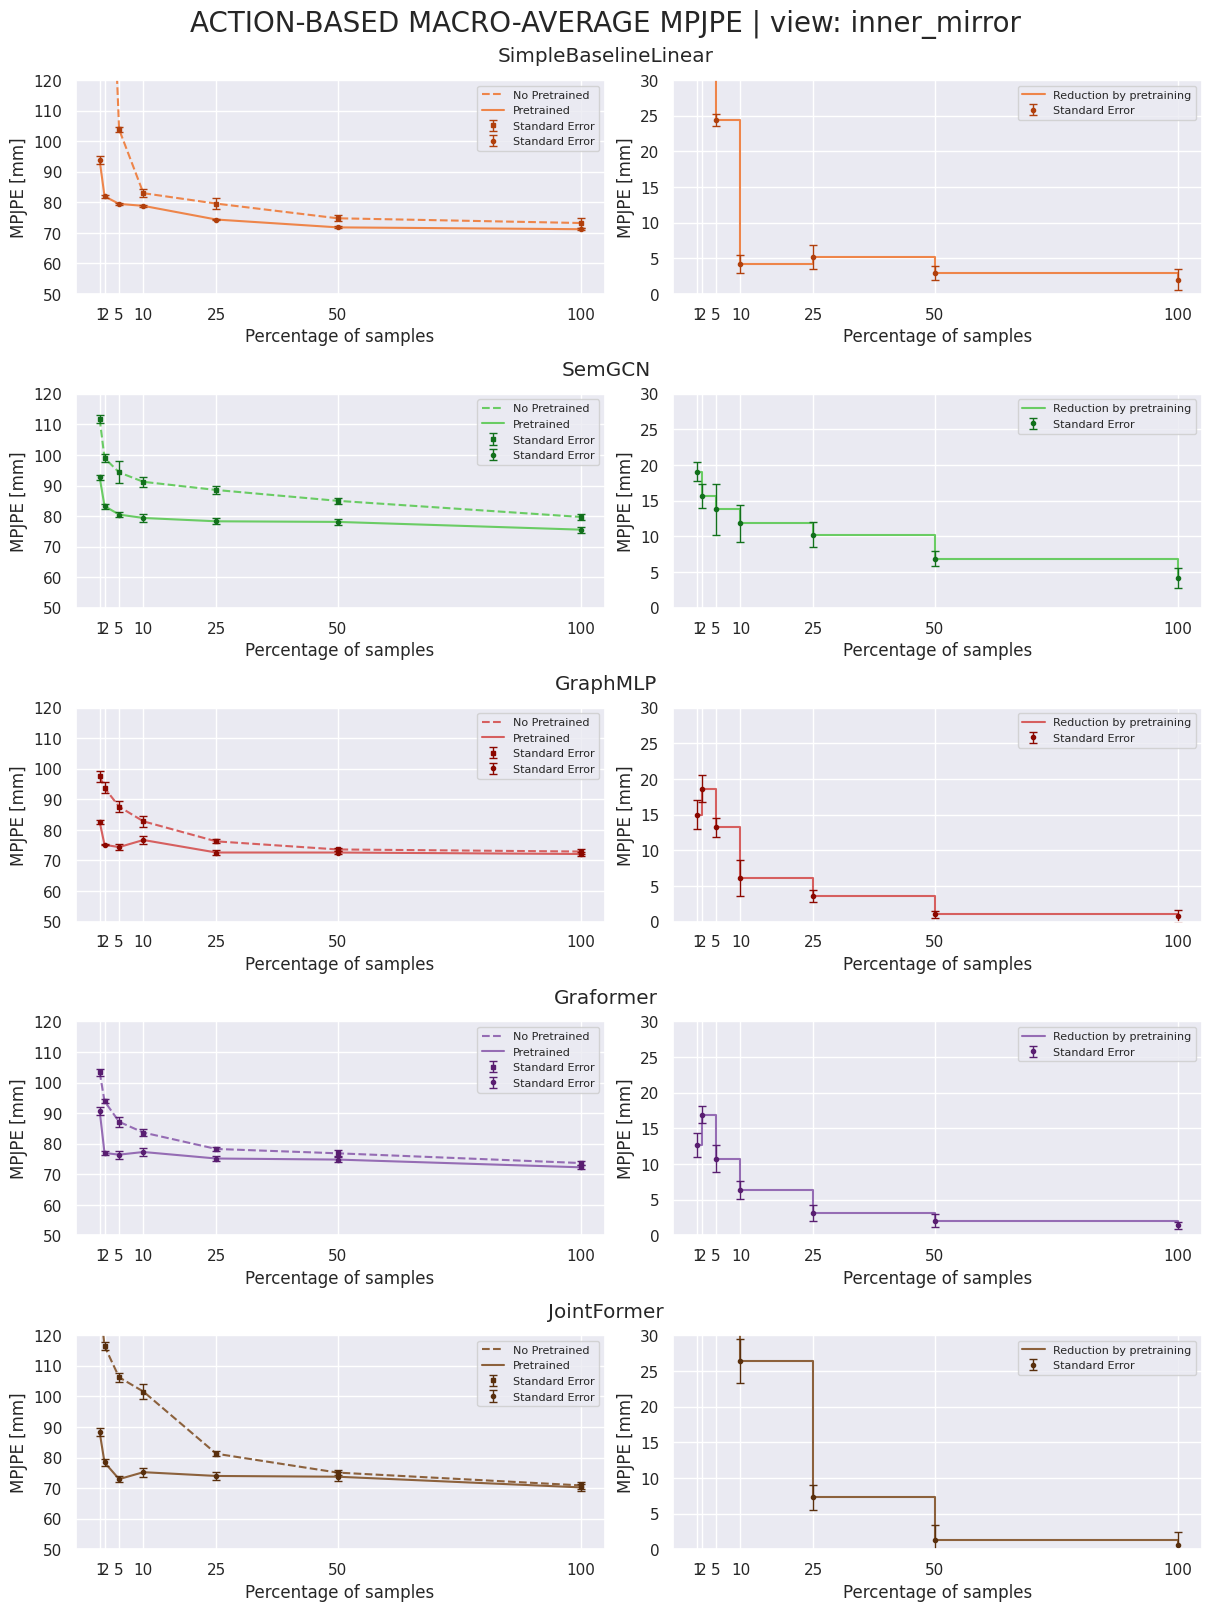

In [10]:
view_point_mean, view_point_stderr = calculate_summary_results('activity_macro_mpjpe')
raw_df, ft_df = get_summarize_table(DRIVE_AND_ACT_VIEWPOINTS[2], subset_percentage, view_point_mean, view_point_stderr)
display('No Pretrained')
print_table(raw_df)
display('Pretrained')
print_table(ft_df)
display('Diff')
print_table(raw_df - ft_df)
plot_result('ACTION-BASED MACRO-AVERAGE MPJPE', DRIVE_AND_ACT_VIEWPOINTS[2], view_point_mean, view_point_stderr)